# 1. Library Imports

In [14]:
import scanpy as sc
import matplotlib.pyplot as plt
import igraph
import leidenalg

# 2. Data Processing

## 2.1 Loading Data

In [15]:
adata = sc.read_10x_mtx(
    path="../data/raw/pbmc3k/", 
    var_names="gene_symbols",
    cache=True
)

print(adata)
print(adata.shape)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
(2700, 32738)


# 2.2 Quality Control & Preprocessing

Flag genes that start with "-MT", which indicate mitochondiral genes. High expression of these genes often indicates cell stress or dying cells. As a result, cells with excessive mitochondrial expression are deemed low-quality data and are filtered-out. 

Add metrics to identift low-quality / outlier cells:
- `n_genes_by_counts`: number of genes detected per cell
- `total_counts`: total UMI counts per cell
- `pct_count_mt`: % of total counts from mitochondrial genes

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

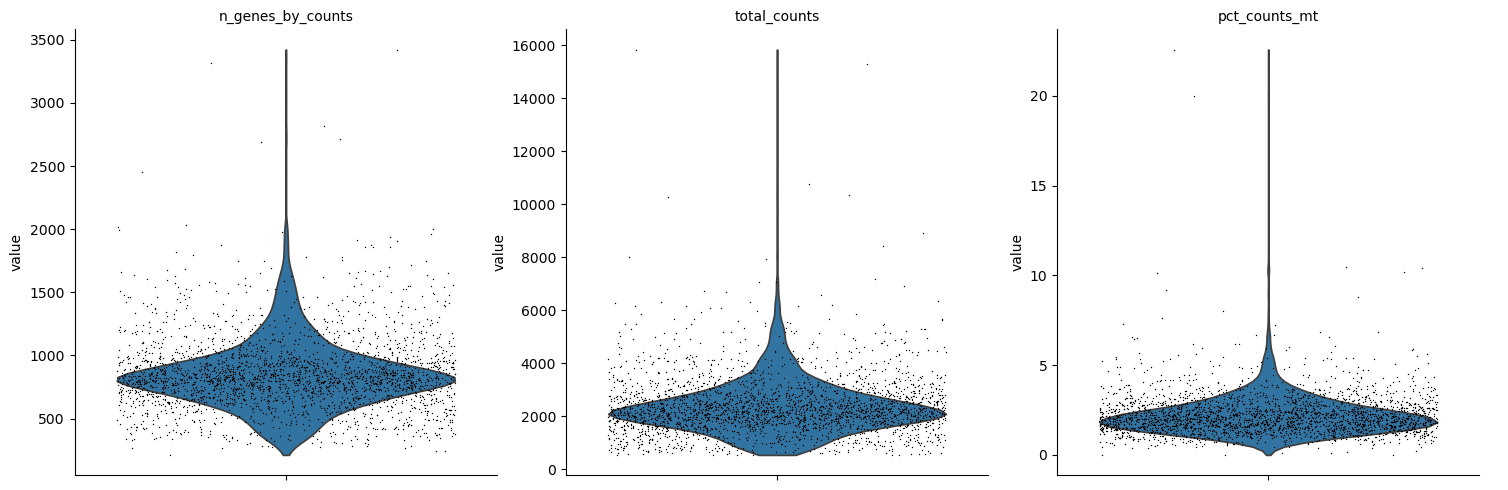

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

### 2.2.1 Filtering & Normalization

Cells with very few genes detected are likely dead or damaged. Cells with extremely low or high count may be low-quality or doublets. High mitochondrial fraction indicates stressed/drying cells. As a result, cells are filtered-out following the cutoffs:
- `n_genes_by_counts` < 200
- `n_genes_by_counts` > 2500
- `pct_counts_mt` > 5%

In [18]:
adata = adata[
    (adata.obs.n_genes_by_counts > 200) &
    (adata.obs.n_genes_by_counts < 2500) &
    (adata.obs.pct_counts_mt < 5),
    :
]

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/opt/anaconda3/envs/scrna-pbmc/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### 2.2.2 Identify Highly Variable Genes (HVGs)

Identify genes whose expression varies greatly across cells, beyond the expected noise in the data. By filtering to HVGs, denoise data and reduce dimensionality to focus on biologically inofmative signal for downstream analysis. 

Ignore genes with low average expression across cells (`0.0125`) and genes with high average expression across cells to remove saturation effects (`3`). In addition, only keep genes with higher-then-expected variance (`0.5`) for their mean expression to identify truly variable genes relative to their expression level.

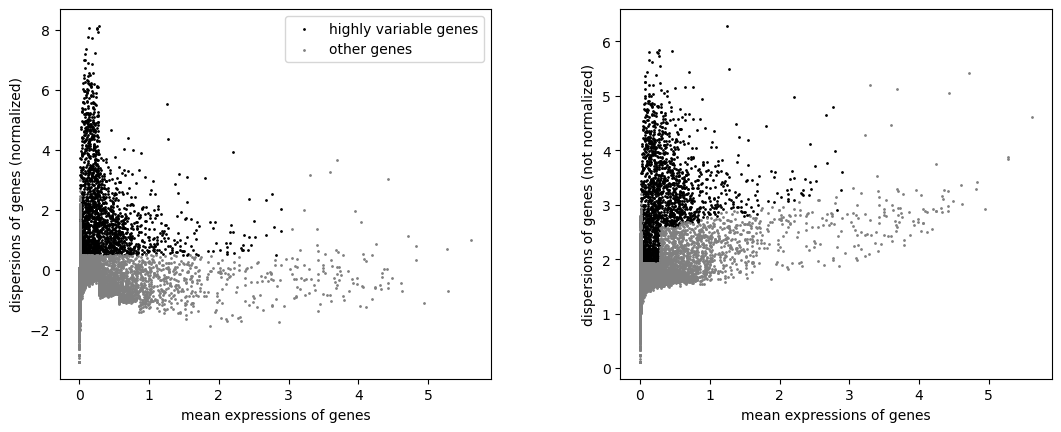

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata) # Visualize HVGs
adata = adata[:, adata.var.highly_variable]

### 2.2.3 Scaling & Regressing Out

Perform linear regression for each gene separately to remove technical noise. Some cells have more UMIs simply because they captured more RNA, not because they are biologically different.

Center each gene's expression to have zero mean and variance of one, clipping extreme values/outliers (`10`).

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/opt/anaconda3/envs/scrna-pbmc/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:729: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# 3. PCA

After preprocessing and selection, run Principal Component Analysis (PCA) to reduce dimensionality of gene expression features into a smaller set of principal components and capture the most meaningful variance across cells. 

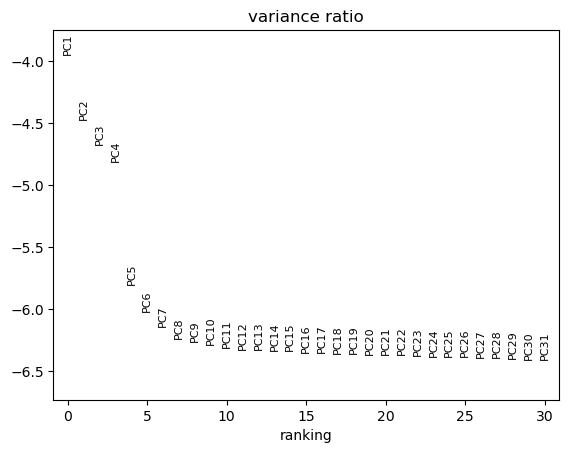

In [22]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

# 4. Neighbors, UMAP, and Leiden Clustering

Construct a K-nearest Neighbors Graph that connects transcriptionally similar cells using the principal components. 

Use this graph to build a 2D embedding that preserves both local and global cell similarities using the Uniform Manifold Approximation and Projection algorithm, to capture non-linear structures in visualization. 

Use the unsupervised algorithm Leiden Clustering to detect clusters of similar cells in the graph which often belong to distinct cell types. Clusters are annotated by plotting marker genes (`MS4A1` for B cells, `NKG7` for NK cells, and `CST3` for Monocytes)

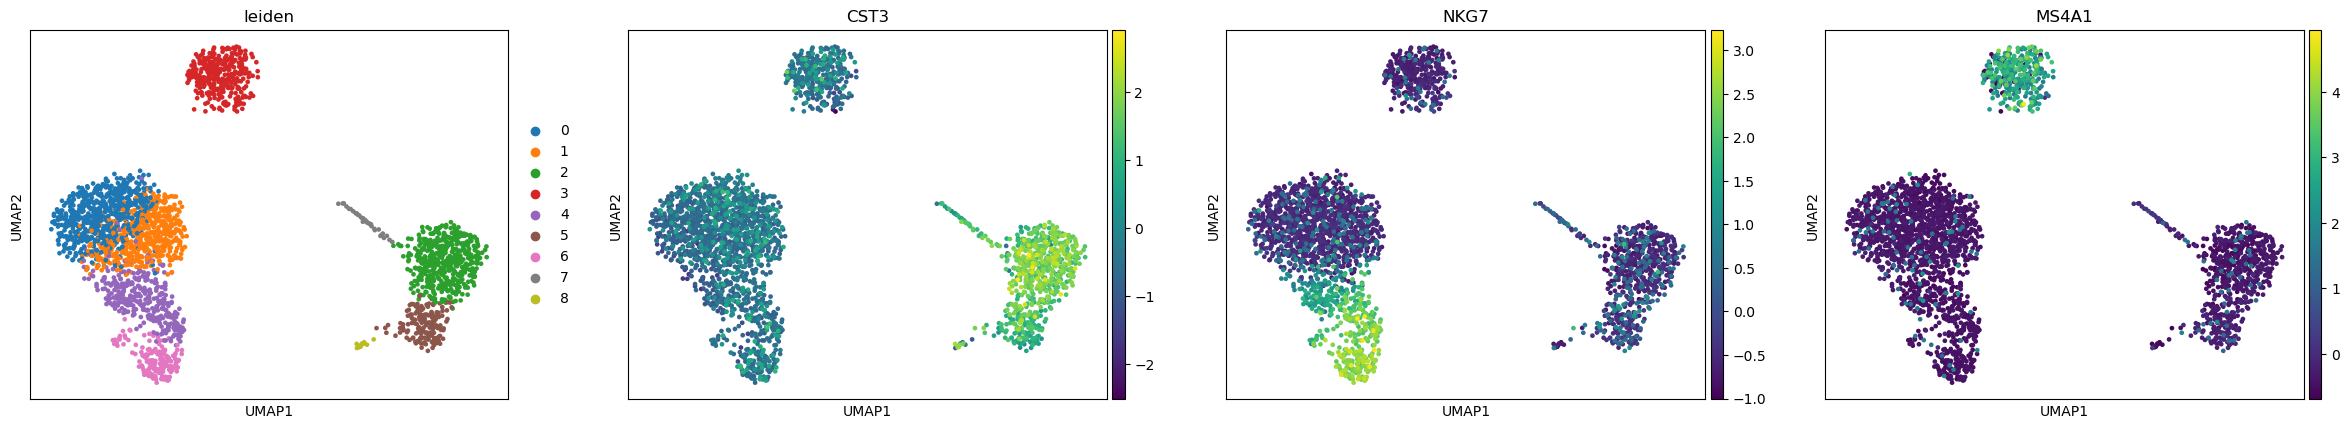

In [23]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7', 'MS4A1'])

# 5. Save Pre-Processed Data

In [24]:
print(adata.shape)

(2638, 2013)


In [25]:
adata.write("../data/processed/pbmc3k_preprocessed.h5ad")